# Transfer Learning

## Prepare dataloader

In [1]:
import dataset
from torchvision import transforms

# Create training transform with TrivialAugment
all_transform = transforms.Compose([
    dataset.SquarePad(fill=255),
    transforms.Resize((224,224)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataloader, test_dataloader, validate_dataloader, names = dataset.create_dataloaders(
        train_transform=all_transform,
        test_transform=all_transform,
        validate_transform=all_transform,
    )

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(names)

['RG01 RX-78-2 Gundam', "RG02 MS-06S Char's Zaku II", 'RG03 GAT-X-105 Aile Strike Gundam', 'RG04 MS-06F Zaku II', 'RG05 ZGMF-X10A Freedom Gundam', 'RG06 FX-550 Sky Grasper', 'RG07 RX-178 Gundam Mk-II Titans', 'RG08 RX-178 Gundam Mk-II A.E.U.G.', 'RG09 ZGMF-X09A Justice Gundam', 'RG10 MSZ-006 Zeta Gundam', 'RG11 ZGMF-X42S Destiny Gundam', 'RG12 RX-78GP01 Zephyranthes', 'RG13 RX-78GP01fb Full Burnern', 'RG14 ZGMF-X20A Strike Freedom Gundam', 'RG15 GN-001 Gundam Exia', "RG16 MSM-07S Char's Z'gok", 'RG17 XXXG-00W0 Wing Gundam Zero EW', 'RG18 GN-0000-GNR-010 OO Raiser', 'RG19 MBF-P02 Gundam Astray Red Frame', 'RG20 XXXG-01W Wing Gundam EW', 'RG21 GNT-0000 OO Qan[T]', 'RG22 MSN-06S Sinanju', 'RG23 Build Strike Gundam Full Package', 'RG24 Gundam Astray Gold Frame Amatsu Mina', 'RG25 RX-0 Unicorn Gundam', "RG26 MS-06R-2 Johnny Ridden's Zaku II", 'RG27 RX-0[N] Unicorn Gundam 02 Banshee Norn', 'RG28 OZ-00MS Tallgeese EW', 'RG29 MSN-04 Sazabi', 'RG30 RX-0 Full Armor Unicorn Gundam', 'RG31 XM-X1 C

## Hyper parameters


In [3]:
EPOCHS=20
LEARNING_RATE=0.001
OUTPUT_SIZE=len(names)

## The pretained EfficentNet Model

In [4]:
import torch
import torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
efficentnet_b0_unargument = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [5]:
import utils
utils.summary(efficentnet_b0_unargument,
        input_size=(32, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

## Freezing the base model and changing the output layer to suit our needs

In [6]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in efficentnet_b0_unargument.features.parameters():
    param.requires_grad = False

In [7]:
import utils

utils.set_seeds()

# Recreate the classifier layer and seed it to the target device
efficentnet_b0_unargument.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=OUTPUT_SIZE, # same number of output units as our number of classes
                    bias=True)).to(device)

In [8]:
utils.summary(efficentnet_b0_unargument,
        input_size=(32, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 37]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Train the model

[INFO] Created SummaryWriter, saving to: ./runs/2022-11-09/efficentnet_b0_unargument...


  5%| | 1/20 [00:09<

Epoch: 1 | train_loss: 3.0032 | train_acc: 0.2829 | test_loss: 2.3543 | test_acc: 0.5365


 10%| | 2/20 [00:17<

Epoch: 2 | train_loss: 2.0336 | train_acc: 0.6071 | test_loss: 1.8170 | test_acc: 0.6240


 15%|▏| 3/20 [00:25<

Epoch: 3 | train_loss: 1.5581 | train_acc: 0.6987 | test_loss: 1.5227 | test_acc: 0.6531


 20%|▏| 4/20 [00:33<

Epoch: 4 | train_loss: 1.3026 | train_acc: 0.7394 | test_loss: 1.3782 | test_acc: 0.6948


 25%|▎| 5/20 [00:41<

Epoch: 5 | train_loss: 1.1258 | train_acc: 0.7826 | test_loss: 1.2845 | test_acc: 0.6979


 30%|▎| 6/20 [00:49<

Epoch: 6 | train_loss: 0.9993 | train_acc: 0.8070 | test_loss: 1.2143 | test_acc: 0.7073


 35%|▎| 7/20 [00:58<

Epoch: 7 | train_loss: 0.8860 | train_acc: 0.8311 | test_loss: 1.1571 | test_acc: 0.7208


 40%|▍| 8/20 [01:06<

Epoch: 8 | train_loss: 0.8064 | train_acc: 0.8441 | test_loss: 1.0998 | test_acc: 0.7344


 45%|▍| 9/20 [01:14<

Epoch: 9 | train_loss: 0.7553 | train_acc: 0.8537 | test_loss: 1.0732 | test_acc: 0.7312


 50%|▌| 10/20 [01:22

Epoch: 10 | train_loss: 0.6907 | train_acc: 0.8745 | test_loss: 1.0359 | test_acc: 0.7417


 55%|▌| 11/20 [01:29

Epoch: 11 | train_loss: 0.6477 | train_acc: 0.8815 | test_loss: 1.0257 | test_acc: 0.7365


 60%|▌| 12/20 [01:37

Epoch: 12 | train_loss: 0.6125 | train_acc: 0.8857 | test_loss: 1.0019 | test_acc: 0.7438


 65%|▋| 13/20 [01:45

Epoch: 13 | train_loss: 0.5560 | train_acc: 0.9011 | test_loss: 0.9867 | test_acc: 0.7385


 70%|▋| 14/20 [01:53

Epoch: 14 | train_loss: 0.5194 | train_acc: 0.8995 | test_loss: 0.9752 | test_acc: 0.7469


 75%|▊| 15/20 [02:02

Epoch: 15 | train_loss: 0.4869 | train_acc: 0.9105 | test_loss: 0.9723 | test_acc: 0.7510


 80%|▊| 16/20 [02:10

Epoch: 16 | train_loss: 0.4638 | train_acc: 0.9240 | test_loss: 0.9578 | test_acc: 0.7510


 85%|▊| 17/20 [02:18

Epoch: 17 | train_loss: 0.4538 | train_acc: 0.9173 | test_loss: 0.9505 | test_acc: 0.7521


 90%|▉| 18/20 [02:26

Epoch: 18 | train_loss: 0.4492 | train_acc: 0.9216 | test_loss: 0.9256 | test_acc: 0.7604


 95%|▉| 19/20 [02:34

Epoch: 19 | train_loss: 0.4016 | train_acc: 0.9316 | test_loss: 0.9227 | test_acc: 0.7615


100%|█| 20/20 [02:42

Epoch: 20 | train_loss: 0.4019 | train_acc: 0.9260 | test_loss: 0.9119 | test_acc: 0.7521
Saving model to: ./models/efficentnet_b0_unargument.pt


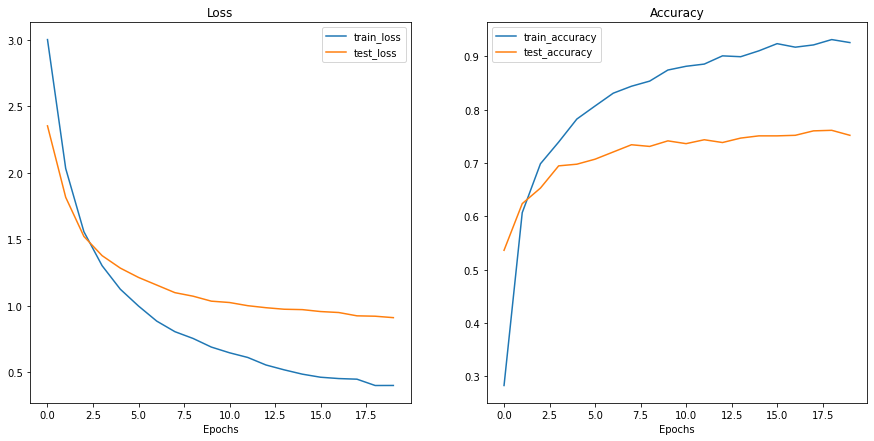

In [9]:
import utils

optimizer = torch.optim.Adam(efficentnet_b0_unargument.parameters(),
                                lr=LEARNING_RATE)

loss_fn = torch.nn.CrossEntropyLoss()


_=utils.train_and_save(
    model=efficentnet_b0_unargument,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=device,
    epochs=EPOCHS,
    model_name="efficentnet_b0_unargument",
)

## Evaluating the performance

In [10]:
import engine

metrics=engine.test_step(
    model=efficentnet_b0_unargument,
    dataloader=validate_dataloader,
    loss_fn=loss_fn,
    device=device,
)

print (metrics)

(2.8805216380528043, 0.3586309523809524)


## Making predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG32/61+MbjJ58TL._AC_SL1500_.jpg
RG24 Gundam Astray Gold Frame Amatsu Mina : 0.130
RG27 RX-0[N] Unicorn Gundam 02 Banshee Norn : 0.078
RG02 MS-06S Char's Zaku II : 0.076


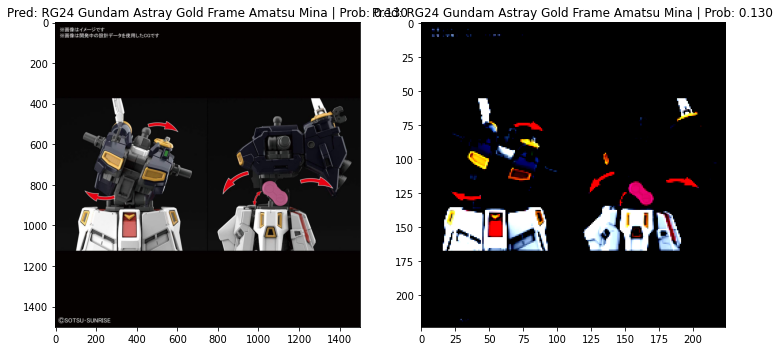

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG19/71UxybFSQ7L._AC_SX679_.jpg
RG19 MBF-P02 Gundam Astray Red Frame : 0.239
RG06 FX-550 Sky Grasper : 0.197
RG03 GAT-X-105 Aile Strike Gundam : 0.136


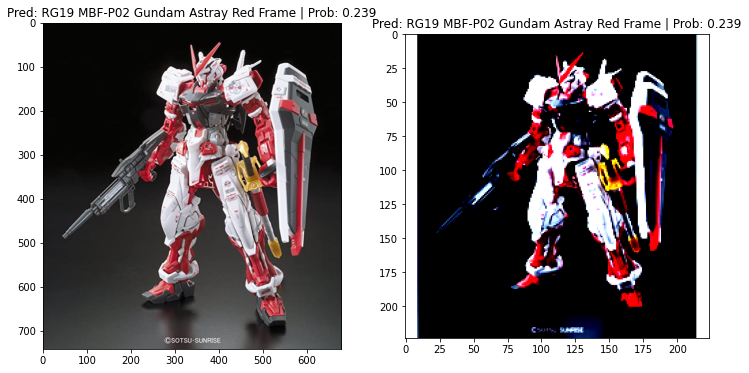

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG15/71VEVg4WxhL._AC_SX679_.jpg
RG37 GF13-017NJII God Gundam : 0.255
RG33 ZGMF-X56S_α Force Impulse Gundam : 0.204
RG25 RX-0 Unicorn Gundam : 0.126


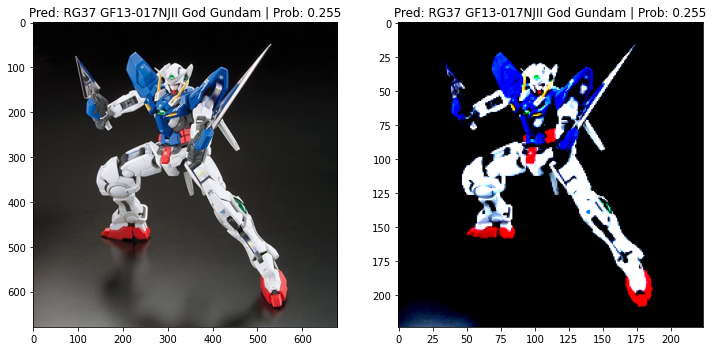

In [12]:
import data_utils
import inference

imgs=data_utils.get_random_images("./data/gunpla/validate", k=3)

for img in imgs:
    print (f"Path {img}")
    inference.predict(
        model=efficentnet_b0_unargument, 
        image_path=img, 
        class_names=names,
        transform=all_transform, 
        topk=3)

# EfficientNet_B2 without argument

## Creating the model

In [13]:
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # .DEFAULT = best available weights 
efficentnet_b2_unargument = torchvision.models.efficientnet_b2(weights=weights).to(device)

utils.summary(efficentnet_b2_unargument,        input_size=(32, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [22]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in efficentnet_b2_unargument.features.parameters():
    param.requires_grad = False

# Recreate the classifier layer and seed it to the target device
efficentnet_b2_unargument.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1408,         # note: this is different from b0
                    out_features=OUTPUT_SIZE, # same number of output units as our number of classes
                    bias=True)).to(device)

import torchinfo
#torchinfo.summary(efficentnet_b2_unargument)
utils.summary(efficentnet_b2_unargument,  input_size=(32, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 37]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Training

[INFO] Created SummaryWriter, saving to: ./runs/2022-11-09/efficentnet_b2_unargument...


  5%| | 1/20 [00:09<

Epoch: 1 | train_loss: 3.0872 | train_acc: 0.2572 | test_loss: 2.5419 | test_acc: 0.4969


 10%| | 2/20 [00:19<

Epoch: 2 | train_loss: 2.1494 | train_acc: 0.5836 | test_loss: 2.0244 | test_acc: 0.5792


 15%|▏| 3/20 [00:29<

Epoch: 3 | train_loss: 1.6744 | train_acc: 0.6749 | test_loss: 1.7370 | test_acc: 0.6208


 20%|▏| 4/20 [00:39<

Epoch: 4 | train_loss: 1.3939 | train_acc: 0.7292 | test_loss: 1.5703 | test_acc: 0.6531


 25%|▎| 5/20 [00:49<

Epoch: 5 | train_loss: 1.2131 | train_acc: 0.7631 | test_loss: 1.4660 | test_acc: 0.6656


 30%|▎| 6/20 [00:59<

Epoch: 6 | train_loss: 1.0458 | train_acc: 0.7968 | test_loss: 1.3910 | test_acc: 0.6833


 35%|▎| 7/20 [01:09<

Epoch: 7 | train_loss: 0.9721 | train_acc: 0.8108 | test_loss: 1.3278 | test_acc: 0.6781


 40%|▍| 8/20 [01:19<

Epoch: 8 | train_loss: 0.8572 | train_acc: 0.8403 | test_loss: 1.2844 | test_acc: 0.6906


 45%|▍| 9/20 [01:29<

Epoch: 9 | train_loss: 0.7986 | train_acc: 0.8505 | test_loss: 1.2456 | test_acc: 0.6865


 50%|▌| 10/20 [01:39

Epoch: 10 | train_loss: 0.7479 | train_acc: 0.8557 | test_loss: 1.2186 | test_acc: 0.6833


 55%|▌| 11/20 [01:49

Epoch: 11 | train_loss: 0.6907 | train_acc: 0.8660 | test_loss: 1.1982 | test_acc: 0.6917


 60%|▌| 12/20 [01:59

Epoch: 12 | train_loss: 0.6599 | train_acc: 0.8710 | test_loss: 1.1690 | test_acc: 0.7010


 65%|▋| 13/20 [02:10

Epoch: 13 | train_loss: 0.5876 | train_acc: 0.8945 | test_loss: 1.1383 | test_acc: 0.7021


 70%|▋| 14/20 [02:20

Epoch: 14 | train_loss: 0.5586 | train_acc: 0.8909 | test_loss: 1.1435 | test_acc: 0.6927


 75%|▊| 15/20 [02:30

Epoch: 15 | train_loss: 0.5300 | train_acc: 0.9079 | test_loss: 1.1240 | test_acc: 0.7031


 80%|▊| 16/20 [02:40

Epoch: 16 | train_loss: 0.5014 | train_acc: 0.9084 | test_loss: 1.1130 | test_acc: 0.7031


 85%|▊| 17/20 [02:50

Epoch: 17 | train_loss: 0.4897 | train_acc: 0.9056 | test_loss: 1.1114 | test_acc: 0.7021


 90%|▉| 18/20 [03:00

Epoch: 18 | train_loss: 0.4546 | train_acc: 0.9151 | test_loss: 1.0893 | test_acc: 0.7031


 95%|▉| 19/20 [03:10

Epoch: 19 | train_loss: 0.4697 | train_acc: 0.9086 | test_loss: 1.0906 | test_acc: 0.7083


100%|█| 20/20 [03:20

Epoch: 20 | train_loss: 0.4120 | train_acc: 0.9264 | test_loss: 1.1036 | test_acc: 0.6990
Saving model to: ./models/efficentnet_b2_unargument.pt


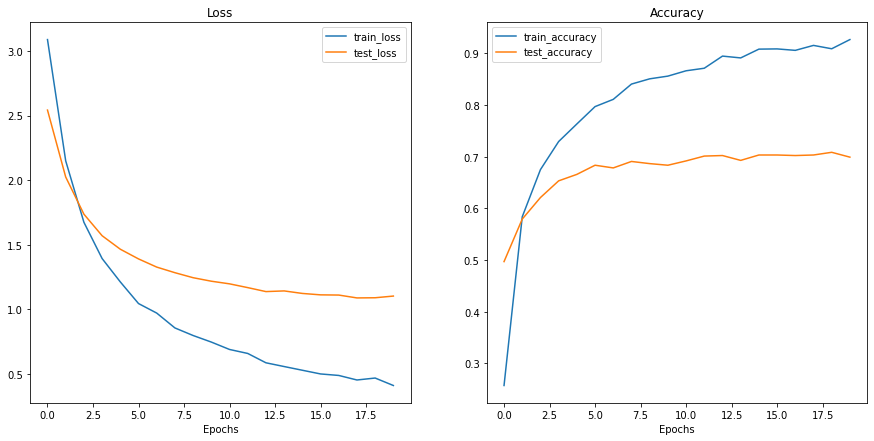

In [15]:
optimizer = torch.optim.Adam(efficentnet_b2_unargument.parameters(),
                                lr=LEARNING_RATE)

loss_fn = torch.nn.CrossEntropyLoss()


_=utils.train_and_save(
    model=efficentnet_b2_unargument,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=device,
    epochs=EPOCHS,
    model_name="efficentnet_b2_unargument",
)

## Evaluate

In [16]:
metrics=engine.test_step(
    model=efficentnet_b0_unargument,
    dataloader=validate_dataloader,
    loss_fn=loss_fn,
    device=device,
)

print (metrics)

(2.6422782284872874, 0.41666666666666663)


# EfficientNet_B0 with argument

## Creating the dataloaders

In [17]:
import dataset
from torchvision import transforms

# Create training transform with TrivialAugment
train_transform = transforms.Compose([
    dataset.SquarePad(fill=255),
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_validate_transform = transforms.Compose([
    dataset.SquarePad(fill=255),
    transforms.Resize((224,224)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataloader, test_dataloader, validate_dataloader, names = dataset.create_dataloaders(
        train_transform=train_transform,
        test_transform=test_validate_transform,
        validate_transform=test_validate_transform,
    )

## Creating the model

In [20]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
efficentnet_b0_argument = torchvision.models.efficientnet_b0(weights=weights).to(device)

utils.summary(efficentnet_b0_argument, input_size=(32, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [21]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in efficentnet_b0_argument.features.parameters():
    param.requires_grad = False

# Recreate the classifier layer and seed it to the target device
efficentnet_b0_argument.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=OUTPUT_SIZE, # same number of output units as our number of classes
                    bias=True)).to(device)

import torchinfo
utils.summary(efficentnet_b0_argument,  input_size=(32, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 37]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Training

[INFO] Created SummaryWriter, saving to: ./runs/2022-11-09/efficentnet_b0_argument...


  5%| | 1/20 [00:10<

Epoch: 1 | train_loss: 3.1794 | train_acc: 0.2190 | test_loss: 2.4962 | test_acc: 0.5073


 10%| | 2/20 [00:20<

Epoch: 2 | train_loss: 2.4395 | train_acc: 0.4665 | test_loss: 1.9845 | test_acc: 0.5958


 15%|▏| 3/20 [00:31<

Epoch: 3 | train_loss: 2.0536 | train_acc: 0.5330 | test_loss: 1.6832 | test_acc: 0.6458


 20%|▏| 4/20 [00:42<

Epoch: 4 | train_loss: 1.8328 | train_acc: 0.5837 | test_loss: 1.5108 | test_acc: 0.6562


 25%|▎| 5/20 [00:52<

Epoch: 5 | train_loss: 1.6597 | train_acc: 0.6091 | test_loss: 1.3847 | test_acc: 0.6771


 30%|▎| 6/20 [01:03<

Epoch: 6 | train_loss: 1.5469 | train_acc: 0.6400 | test_loss: 1.2913 | test_acc: 0.6854


 35%|▎| 7/20 [01:13<

Epoch: 7 | train_loss: 1.4663 | train_acc: 0.6460 | test_loss: 1.2368 | test_acc: 0.7063


 40%|▍| 8/20 [01:23<

Epoch: 8 | train_loss: 1.4070 | train_acc: 0.6558 | test_loss: 1.1724 | test_acc: 0.7104


 45%|▍| 9/20 [01:34<

Epoch: 9 | train_loss: 1.2985 | train_acc: 0.6849 | test_loss: 1.1234 | test_acc: 0.7219


 50%|▌| 10/20 [01:45

Epoch: 10 | train_loss: 1.2866 | train_acc: 0.6904 | test_loss: 1.1012 | test_acc: 0.7208


 55%|▌| 11/20 [01:55

Epoch: 11 | train_loss: 1.2386 | train_acc: 0.7014 | test_loss: 1.0733 | test_acc: 0.7250


 60%|▌| 12/20 [02:06

Epoch: 12 | train_loss: 1.2296 | train_acc: 0.6852 | test_loss: 1.0375 | test_acc: 0.7323


 65%|▋| 13/20 [02:16

Epoch: 13 | train_loss: 1.2219 | train_acc: 0.6934 | test_loss: 1.0308 | test_acc: 0.7344


 70%|▋| 14/20 [02:26

Epoch: 14 | train_loss: 1.1493 | train_acc: 0.6920 | test_loss: 0.9948 | test_acc: 0.7406


 75%|▊| 15/20 [02:37

Epoch: 15 | train_loss: 1.1368 | train_acc: 0.7202 | test_loss: 0.9824 | test_acc: 0.7396


 80%|▊| 16/20 [02:47

Epoch: 16 | train_loss: 1.1191 | train_acc: 0.7202 | test_loss: 0.9859 | test_acc: 0.7438


 85%|▊| 17/20 [02:58

Epoch: 17 | train_loss: 1.0721 | train_acc: 0.7318 | test_loss: 0.9684 | test_acc: 0.7396


 90%|▉| 18/20 [03:09

Epoch: 18 | train_loss: 1.0819 | train_acc: 0.7175 | test_loss: 0.9472 | test_acc: 0.7479


 95%|▉| 19/20 [03:20

Epoch: 19 | train_loss: 1.0558 | train_acc: 0.7395 | test_loss: 0.9467 | test_acc: 0.7573


100%|█| 20/20 [03:31

Epoch: 20 | train_loss: 1.0152 | train_acc: 0.7415 | test_loss: 0.9278 | test_acc: 0.7458
Saving model to: ./models/efficentnet_b0_argument.pt


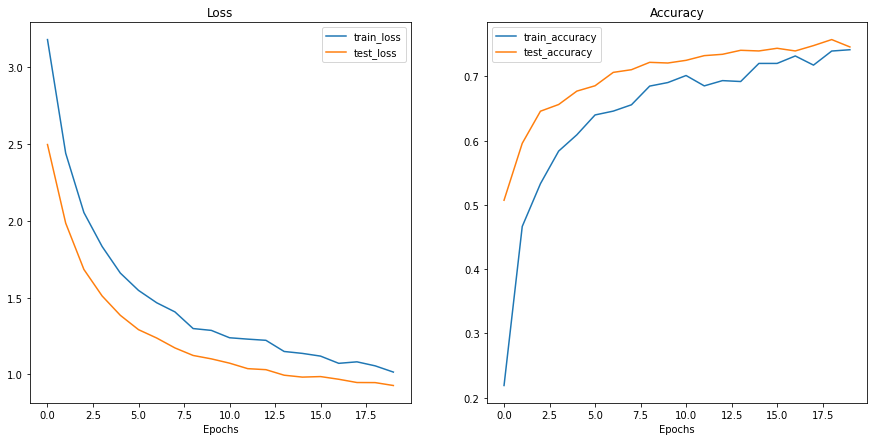

In [23]:
optimizer = torch.optim.Adam(efficentnet_b0_argument.parameters(),
                                lr=LEARNING_RATE)

loss_fn = torch.nn.CrossEntropyLoss()


_=utils.train_and_save(
    model=efficentnet_b0_argument,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=device,
    epochs=EPOCHS,
    model_name="efficentnet_b0_argument",
)

## Evaluate

In [24]:
metrics=engine.test_step(
    model=efficentnet_b0_argument,
    dataloader=validate_dataloader,
    loss_fn=loss_fn,
    device=device,
)

print (metrics)

(1.5679740735462733, 0.5818452380952381)


# EfficientNet_B2 with argument

## Creating the model

In [25]:
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # .DEFAULT = best available weights 
efficentnet_b2_argument = torchvision.models.efficientnet_b2(weights=weights).to(device)

utils.summary(efficentnet_b2_argument,        input_size=(32, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [26]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in efficentnet_b2_argument.features.parameters():
    param.requires_grad = False

# Recreate the classifier layer and seed it to the target device
efficentnet_b2_argument.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1408,         # note: this is different from b0
                    out_features=OUTPUT_SIZE, # same number of output units as our number of classes
                    bias=True)).to(device)

import torchinfo
#torchinfo.summary(efficentnet_b2_unargument)
utils.summary(efficentnet_b2_argument,  input_size=(32, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 37]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Training

[INFO] Created SummaryWriter, saving to: ./runs/2022-11-09/efficentnet_b2_argument...


  5%| | 1/20 [00:12<

Epoch: 1 | train_loss: 3.2422 | train_acc: 0.1757 | test_loss: 2.6855 | test_acc: 0.4573


 10%| | 2/20 [00:23<

Epoch: 2 | train_loss: 2.5275 | train_acc: 0.4386 | test_loss: 2.1617 | test_acc: 0.5687


 15%|▏| 3/20 [00:35<

Epoch: 3 | train_loss: 2.1420 | train_acc: 0.5203 | test_loss: 1.8604 | test_acc: 0.6031


 20%|▏| 4/20 [00:47<

Epoch: 4 | train_loss: 1.8831 | train_acc: 0.5787 | test_loss: 1.6748 | test_acc: 0.6344


 25%|▎| 5/20 [00:58<

Epoch: 5 | train_loss: 1.7319 | train_acc: 0.6044 | test_loss: 1.5603 | test_acc: 0.6521


 30%|▎| 6/20 [01:10<

Epoch: 6 | train_loss: 1.6338 | train_acc: 0.6168 | test_loss: 1.4590 | test_acc: 0.6708


 35%|▎| 7/20 [01:22<

Epoch: 7 | train_loss: 1.5444 | train_acc: 0.6243 | test_loss: 1.4029 | test_acc: 0.6792


 40%|▍| 8/20 [01:33<

Epoch: 8 | train_loss: 1.4503 | train_acc: 0.6532 | test_loss: 1.3549 | test_acc: 0.6833


 45%|▍| 9/20 [01:45<

Epoch: 9 | train_loss: 1.3813 | train_acc: 0.6786 | test_loss: 1.2979 | test_acc: 0.6958


 50%|▌| 10/20 [01:56

Epoch: 10 | train_loss: 1.3583 | train_acc: 0.6819 | test_loss: 1.2747 | test_acc: 0.6865


 55%|▌| 11/20 [02:08

Epoch: 11 | train_loss: 1.2616 | train_acc: 0.7021 | test_loss: 1.2316 | test_acc: 0.6990


 60%|▌| 12/20 [02:19

Epoch: 12 | train_loss: 1.2488 | train_acc: 0.6897 | test_loss: 1.1994 | test_acc: 0.7000


 65%|▋| 13/20 [02:31

Epoch: 13 | train_loss: 1.2177 | train_acc: 0.6949 | test_loss: 1.1673 | test_acc: 0.7125


 70%|▋| 14/20 [02:42

Epoch: 14 | train_loss: 1.2006 | train_acc: 0.6991 | test_loss: 1.1660 | test_acc: 0.7104


 75%|▊| 15/20 [02:54

Epoch: 15 | train_loss: 1.1591 | train_acc: 0.7124 | test_loss: 1.1592 | test_acc: 0.7063


 80%|▊| 16/20 [03:05

Epoch: 16 | train_loss: 1.1359 | train_acc: 0.7141 | test_loss: 1.1406 | test_acc: 0.7146


 85%|▊| 17/20 [03:17

Epoch: 17 | train_loss: 1.0933 | train_acc: 0.7245 | test_loss: 1.1167 | test_acc: 0.7104


 90%|▉| 18/20 [03:29

Epoch: 18 | train_loss: 1.0958 | train_acc: 0.7156 | test_loss: 1.0924 | test_acc: 0.7167


 95%|▉| 19/20 [03:40

Epoch: 19 | train_loss: 1.0596 | train_acc: 0.7324 | test_loss: 1.0909 | test_acc: 0.7135


100%|█| 20/20 [03:52

Epoch: 20 | train_loss: 1.0368 | train_acc: 0.7345 | test_loss: 1.0684 | test_acc: 0.7302
Saving model to: ./models/efficentnet_b2_argument.pt


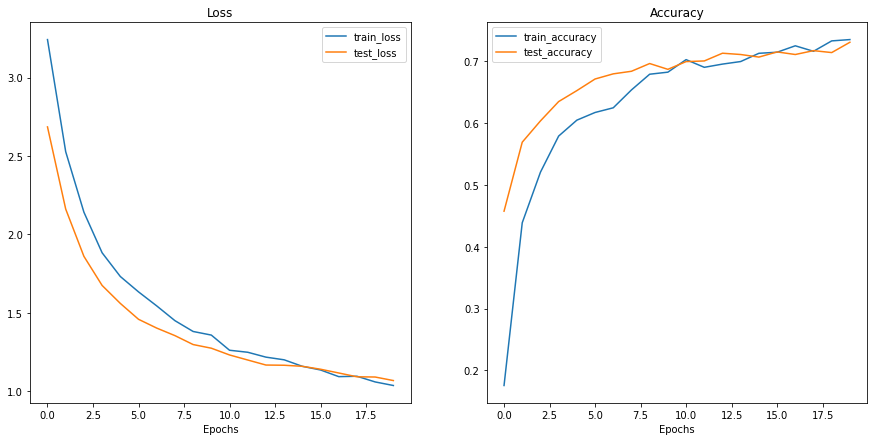

In [27]:
optimizer = torch.optim.Adam(efficentnet_b2_argument.parameters(),
                                lr=LEARNING_RATE)

loss_fn = torch.nn.CrossEntropyLoss()


_=utils.train_and_save(
    model=efficentnet_b2_argument,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=device,
    epochs=EPOCHS,
    model_name="efficentnet_b2_argument",
)

## Evaluate

In [28]:
metrics=engine.test_step(
    model=efficentnet_b2_argument,
    dataloader=validate_dataloader,
    loss_fn=loss_fn,
    device=device,
)

print (metrics)

(1.3411986316953386, 0.6264880952380952)


# Compare different models

In [11]:
%load_ext tensorboard
%tensorboard --logdir runs

# Predicting with best preformance model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG21/615i7KmOE3L._AC_SX679_.jpg
RG21 GNT-0000 OO Qan[T] : 0.769
RG06 FX-550 Sky Grasper : 0.153
RG18 GN-0000-GNR-010 OO Raiser : 0.037


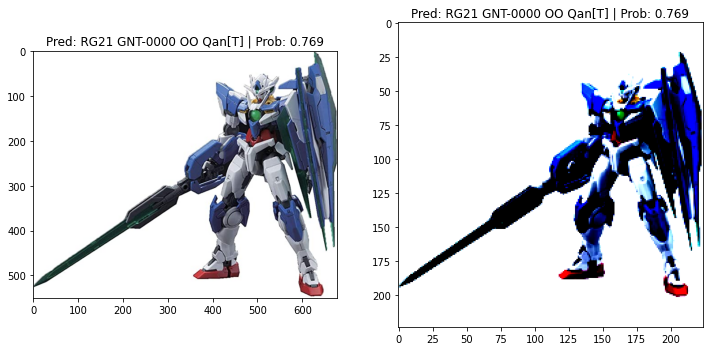

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG24/71L4elpRKxL._AC_SY741_.jpg
RG24 Gundam Astray Gold Frame Amatsu Mina : 0.973
RG35 XXXG-01W Wing Gundam : 0.014
RG06 FX-550 Sky Grasper : 0.003


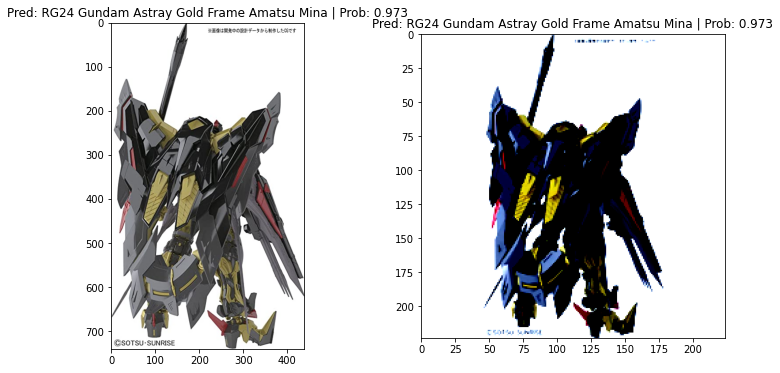

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG06/51Ea4ona4-L._AC_.jpg
RG06 FX-550 Sky Grasper : 0.864
RG21 GNT-0000 OO Qan[T] : 0.032
RG11 ZGMF-X42S Destiny Gundam : 0.018


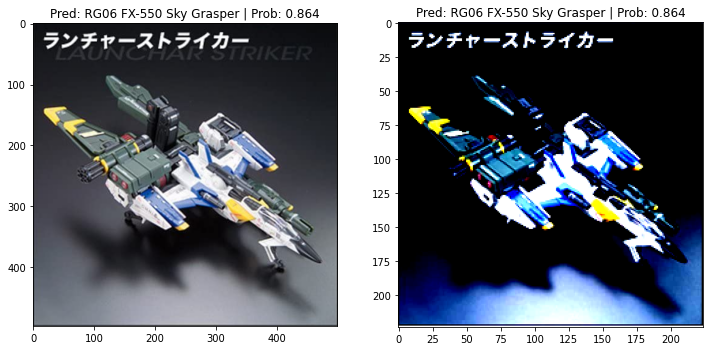

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG31/61RI2Q6iVsL._AC_SX679_.jpg
RG03 GAT-X-105 Aile Strike Gundam : 0.423
RG24 Gundam Astray Gold Frame Amatsu Mina : 0.271
RG23 Build Strike Gundam Full Package : 0.092


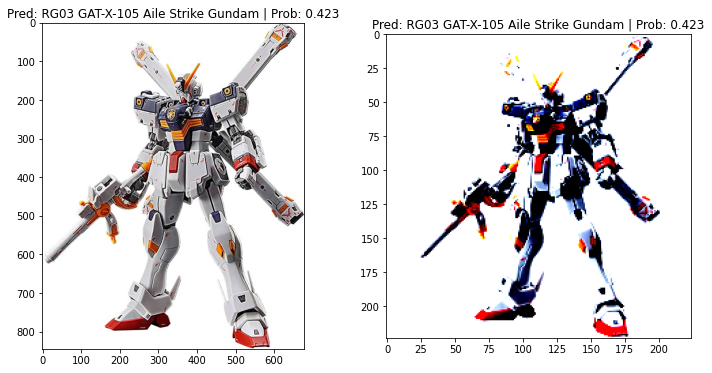

Path data/gunpla/validate/RG34/71LgYPiINoL._AC_SL1500_.jpg
RG17 XXXG-00W0 Wing Gundam Zero EW : 0.250
RG09 ZGMF-X09A Justice Gundam : 0.096
RG01 RX-78-2 Gundam  : 0.092


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


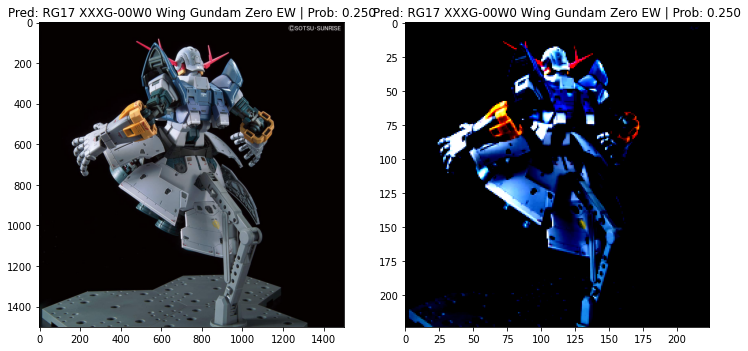

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG31/510lWegjMcL._AC_SX679_.jpg
RG32 RX-93 Nu Gundam : 0.290
RG31 XM-X1 Crossbone Gundam X1 : 0.183
RG01 RX-78-2 Gundam  : 0.068


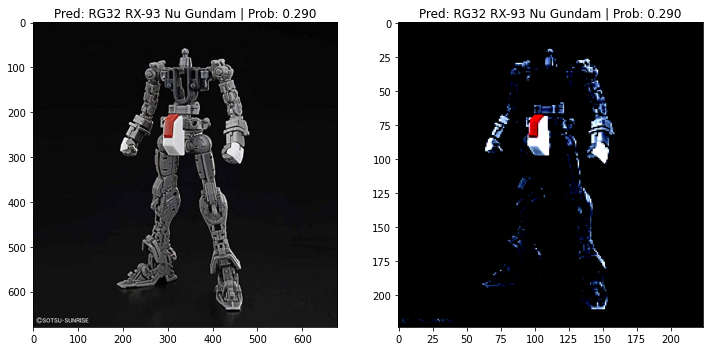

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG34/71+lGRgF5wL._AC_SL1500_.jpg
RG34 MSN-02 Zeong    : 0.394
RG18 GN-0000-GNR-010 OO Raiser : 0.085
RG20 XXXG-01W Wing Gundam EW : 0.081


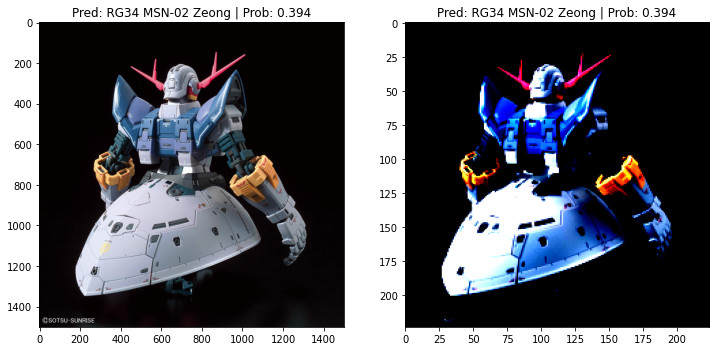

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG32/71YA1quNUcL._AC_SL1500_.jpg
RG27 RX-0[N] Unicorn Gundam 02 Banshee Norn : 0.592
RG24 Gundam Astray Gold Frame Amatsu Mina : 0.273
RG03 GAT-X-105 Aile Strike Gundam : 0.088


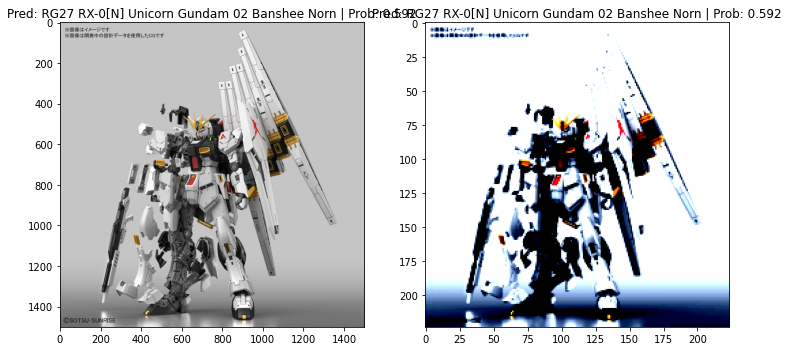

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG25/71Z+ev2VuqL._AC_SX679_.jpg
RG25 RX-0 Unicorn Gundam : 0.895
RG37 GF13-017NJII God Gundam : 0.037
RG31 XM-X1 Crossbone Gundam X1 : 0.026


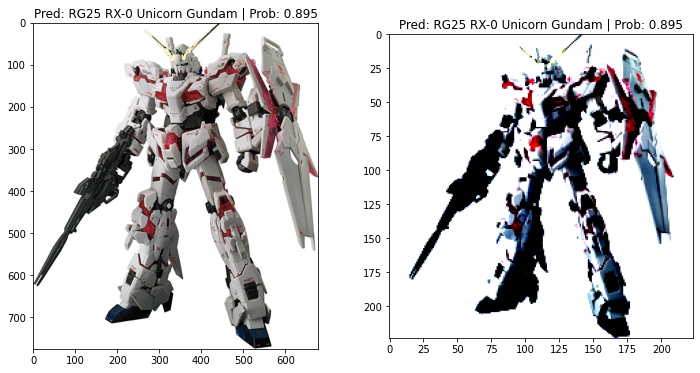

In [30]:
imgs=data_utils.get_random_images("./data/gunpla/validate", k=9)

for img in imgs:
    print (f"Path {img}")
    inference.predict(
        model=efficentnet_b0_unargument, 
        image_path=img, 
        class_names=names,
        transform=all_transform, 
        topk=3)